<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_digit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [0]:
train = datasets.MNIST('', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.MNIST('', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

## Creating the Dataset Tensor

In [0]:
BATCH_SIZE = 32
HEIGHT, WIDTH = 28
TOTAL_PIXELS = HEIGHT*WIDTH

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True)

#### Viewing one Sample

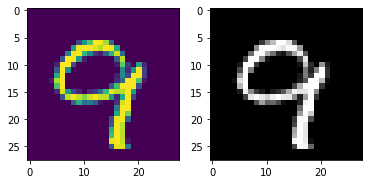

In [71]:
i = 0 # ranging from 0-9
for data in trainSet:
    # data --> one batch containing 32 samples
    x, y = data[0][i], data[1][i]

plt.subplot(1, 2, 1)
plt.imshow(x.view(HEIGHT, WIDTH)) # Reshaping x from (1, Height, Width) --> (Height, Width)

plt.subplot(1, 2, 2)
plt.imshow(x.view(HEIGHT, WIDTH), cmap='gray')

### Checking the Balancing of the Data

Text(0, 0.5, 'Percentage')

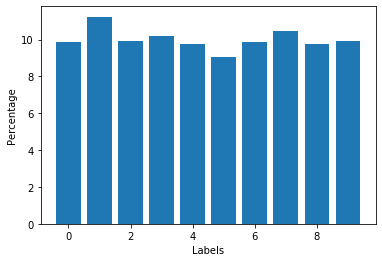

In [0]:
total = 0
counter = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainSet:
        y = data[1]
        for sample in y:
            counter[int(sample)] += 1
            total += 1
            
for key in counter:
    percentage = round(counter[key]/total * 100, 2)
    counter[key] = percentage

x = [key for key in counter]
y = [counter[key] for key in counter]
plt.bar(x, y)
plt.xlabel('Labels')
plt.ylabel('Percentage')

# The Data is BALANCED

## Creating the Network Structure

In [0]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64,    64)        
        self.fc3 = nn.Linear(64,    64)        
        self.fc4 = nn.Linear(64,    28*28)        
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x2 = F.sigmoid(self.fc2(x))        
        x = F.sigmoid(self.fc3(x2))        
        x = F.sigmoid(self.fc4(x))
        
        return x, x2

## Training the Network

In [38]:
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 5

net = Net().to(device)

loss_function = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

loss_log = []
# Iteration Begins
for epoch in range(EPOCHS):
    print('EPOCH :', epoch+1)
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x.to(device), y.to(device) = data
        net.zero_grad()
        
        #Compute the output
        output, layer2 = net(x.view(-1, TOTAL_PIXELS))
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS))
        loss_log.append(loss)
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
    # print(loss)
plt.plot(loss_log)
plt.title('Loss')
plt.grid(1)

  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 15/1875 [00:00<00:12, 145.02it/s]

EPOCH : 1


  1%|          | 15/1875 [00:00<00:12, 145.96it/s]

EPOCH : 2


  1%|          | 15/1875 [00:00<00:12, 147.10it/s]

EPOCH : 3


  1%|          | 15/1875 [00:00<00:12, 148.18it/s]

EPOCH : 4


  1%|          | 15/1875 [00:00<00:13, 140.19it/s]

EPOCH : 5


100%|██████████| 1875/1875 [00:12<00:00, 144.78it/s]


## Encryption Decryption

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5, 1.0, 'Decypted Image')

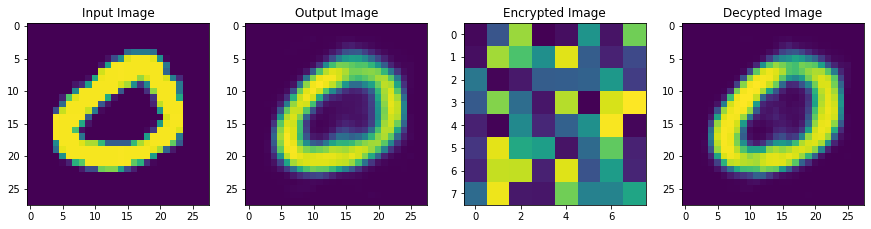

In [90]:
# Selecting a random sample from the dataset
random = np.random.randint(32)

for data in trainSet:
  # print(data)
  sample = data[0][random].view(HEIGHT, WIDTH)
  break


# Passing the sample through the Network and also generating the ENCYPTED IMAGE
with torch.no_grad():
    # for data in trainSet:
        x = sample
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS))


# Converting the tensor into numpy array and reshaping from VECTOR to 2D MATRIX
# trainOutput = trainOutput.view(HEIGHT, WIDTH)
# trainOutput = trainOutput.detach().numpy()*255

testOutput  = testOutput.view(HEIGHT, WIDTH)
testOutput  = testOutput.detach().numpy()*255

encryptedImage  = encryptedImage.view(8, 8)
encryptedImage  = encryptedImage.detach().numpy()*255


# DECRYPTING THE IMAGE
with torch.no_grad():
  x = F.sigmoid(net.fc3((torch.tensor(encryptedImage)).view(-1, 64)))
  # x = F.sigmoid(net.fc3((torch.rand(1, 64))))
  x = F.sigmoid(net.fc4(x))

decryptedImage = x.view(28, 28).detach().numpy()*255


# PLOTTING THE OUTPUTS
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(sample)
plt.title('Input Image')

plt.subplot(1, 4, 2)
plt.imshow(testOutput)
plt.title('Output Image')

plt.subplot(1, 4, 3)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(1, 4, 4)
plt.imshow(decryptedImage)
plt.title('Decypted Image')